In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid", font_scale=2)

In [3]:
trf_score_paths = list(Path("../outputs/notebooks").glob("*/*/trf/trf_scores.csv"))
trf_scores = pd.concat([pd.read_csv(p) for p in trf_score_paths],
                       keys=[(p.parents[2].name, p.parents[1].name) for p in trf_score_paths],
                       names=["model", "equivalence"]).reset_index(level=2, drop=True)
trf_scores = trf_scores.reset_index().melt(id_vars=["model", "equivalence", "fold"], var_name="output_dim", value_name="score").dropna()

trf_scores["model"] = trf_scores.model.str.replace("random[^_]*_", "", regex=True)

trf_scores

,model,equivalence,fold,output_dim,score
0,w2v2_6_8,random,0,0,0.110040
1,w2v2_6_8,random,1,0,0.101601
2,w2v2_6_8,random,2,0,0.102942
3,w2v2_6_3,phoneme,0,0,0.539492
4,w2v2_6_3,phoneme,1,0,0.535647
...,...,...,...,...,...
1411,w2v2_6_32,phoneme_within_word_prefix,1,31,0.639958
1412,w2v2_6_32,phoneme_within_word_prefix,2,31,0.648767
1413,w2v2_6_32,phoneme_within_word_suffix,0,31,0.613305
1414,w2v2_6_32,phoneme_within_word_suffix,1,31,0.605766


In [4]:
score_summary = trf_scores.groupby(["model", "equivalence", "fold"]).apply(lambda xs: pd.Series({"mean_score": xs.score.mean(), "num_dimensions": xs.output_dim.nunique()}))
score_summary

mean_score  num_dimensions
model     equivalence                fold                            
w2v2_6_3  phoneme                    0       0.582147             3.0
                                     1       0.577363             3.0
                                     2       0.582160             3.0
w2v2_6_32 phoneme_within_word_prefix 0       0.598314            32.0
                                     1       0.584813            32.0
                                     2       0.595508            32.0
          phoneme_within_word_suffix 0       0.578922            32.0
                                     1       0.568151            32.0
                                     2       0.578199            32.0
          random                     0       0.148552            32.0
                                     1       0.144097            32.0
                                     2       0.147252            32.0
w2v2_6_8  biphone_pred               0       0.602886             8.0
                                     1       0.596217             8.0
                                     2       0.602760             8.0
          biphone_recon              0       0.568825             8.0
                                     1       0.556644             8.0
                                     2       0.564555             8.0
          next_phoneme               0       0.616899             8.0
                                     1       0.611773             8.0
                                     2       0.617829             8.0
          phoneme                    0       0.596269             8.0
                                     1       0.589155             8.0
                                     2       0.594752             8.0
          phoneme_within_word_prefix 0       0.578876             8.0
                                     1       0.567274             8.0
                                     2       0.579254             8.0
          phoneme_within_word_suffix 0       0.590403             8.0
                                     1       0.581533             8.0
                                     2       0.590786             8.0
          random                     0       0.154619             8.0
                                     1       0.150195             8.0
                                     2       0.152022             8.0
          syllable                   0       0.323861             8.0
                                     1       0.315786             8.0
                                     2       0.326523             8.0
          word                       0       0.094609             8.0
                                     1       0.088837             8.0
                                     2       0.094966             8.0

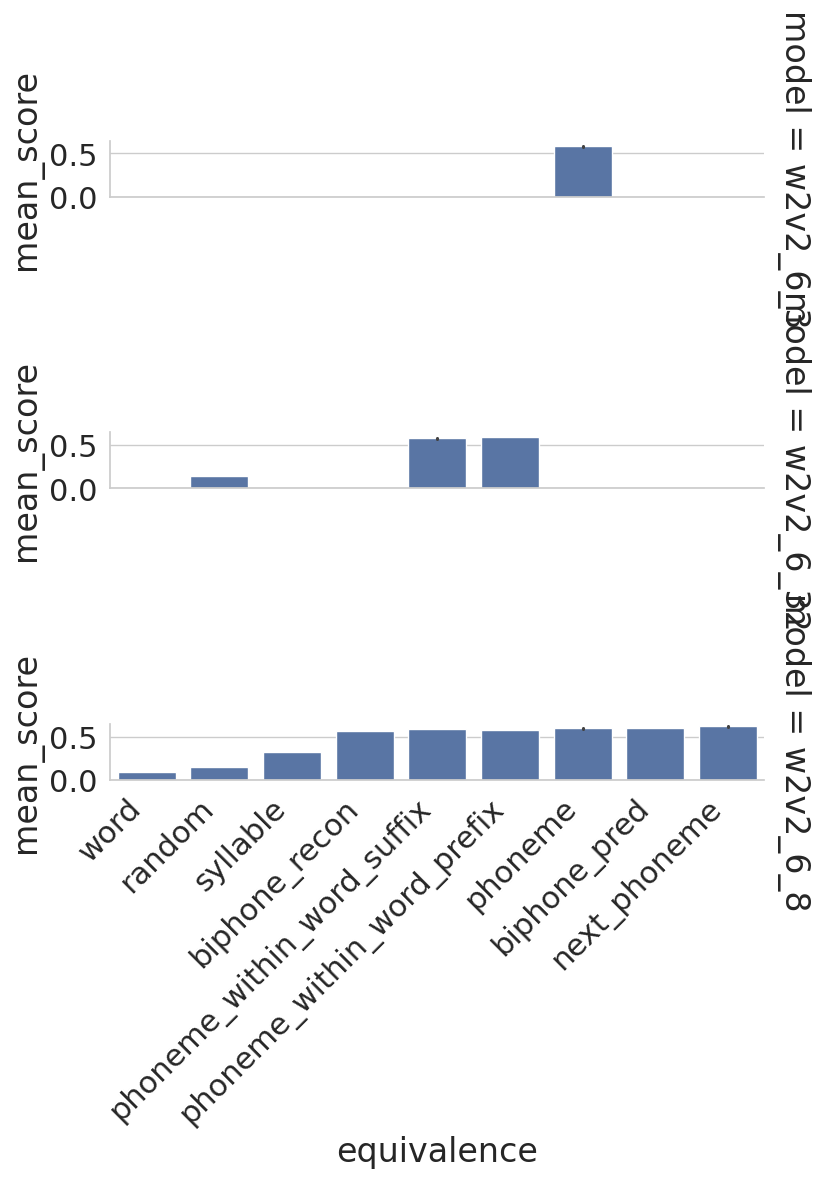

In [5]:
g = sns.FacetGrid(data=score_summary.reset_index(), row="model", margin_titles=True, aspect=3)
g.map(sns.barplot, "equivalence", "mean_score", order=score_summary.groupby("equivalence").mean().sort_values("mean_score").index, errorbar="se")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

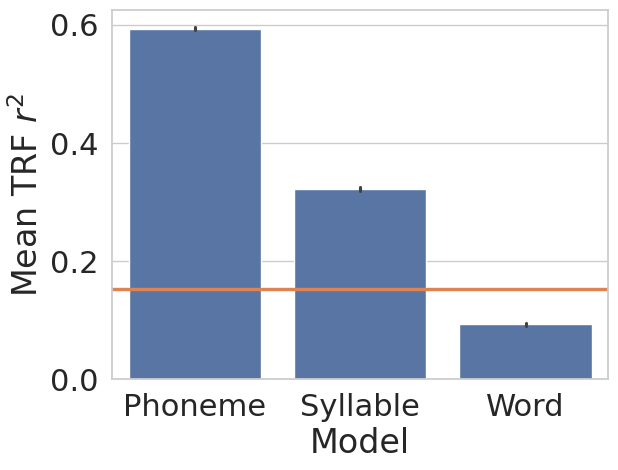

In [18]:
plot_data = score_summary.reset_index()
plot_data = plot_data[plot_data.model == "w2v2_6_8"]
plot_data = plot_data[plot_data.equivalence.isin(["word", "syllable", "phoneme"])]
plot_data["equivalence"] = plot_data.equivalence.str.capitalize()

# Get mean and standard error of random model
random_mean = score_summary.loc["w2v2_6_8"].loc["random"].mean_score.mean()
random_se = score_summary.loc["w2v2_6_8"].loc["random"].mean_score.sem()

ax = sns.barplot(data=plot_data, x="equivalence", y="mean_score", errorbar="se")
ax.set_ylabel("Mean TRF $r^2$")
ax.set_xlabel("Model")

# Plot region of random performance
ax.axhspan(random_mean - random_se, random_mean + random_se, color=sns.color_palette()[1])

In [7]:
ci??

Object `ci` not found.


## Feature selection results

In [19]:
feature_selection_paths = list(Path("../outputs/notebooks").glob("*/*/trf/trf_feature_selection_trajectory.csv"))
feature_selection = pd.concat([pd.read_csv(p) for p in feature_selection_paths],
                              keys=[(p.parents[2].name, p.parents[1].name) for p in feature_selection_paths],
                              names=["model", "equivalence"])

# feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

feature_selection.index.set_names("selection_idx", level=-1, inplace=True)
feature_selection = feature_selection.sort_index().reset_index()
feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

# Compute score deltas
feature_selection["score_diff"] = feature_selection.score.diff()
# Correct for boundaries
feature_selection.loc[feature_selection.selection_idx == 0, "score_diff"] = 0

feature_selection.head(10)

,model,equivalence,selection_idx,Unnamed: 0,category,score,score_diff
0,w2v2_6_32,random,0,0,NaN,0.017284,0.000000
1,w2v2_6_32,random,1,1,consonant_manner,0.072362,0.055078
2,w2v2_6_32,random,2,2,consonant_place,0.108654,0.036291
3,w2v2_6_32,random,3,3,vowel,0.126491,0.017838
4,w2v2_6_8,random,0,0,NaN,0.015372,0.000000
5,w2v2_6_8,random,1,1,consonant_place,0.080950,0.065578
6,w2v2_6_8,random,2,2,consonant_manner,0.114248,0.033298
7,w2v2_6_8,random,3,3,vowel,0.130620,0.016371
8,w2v2_6_32,random,0,0,NaN,0.019205,0.000000
9,w2v2_6_32,random,1,1,consonant_manner,0.099420,0.080214


In [20]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

plot_data = feature_selection[(feature_selection.model == "w2v2_6_8")]
plot_data["category"] = plot_data.category.fillna("baseline")

/tmp/ipykernel_4007273/3410982662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["category"] = plot_data.category.fillna("baseline")


In [22]:
links = []
for (model, equivalence), rows in plot_data.groupby(["model", "equivalence"]):
    for i1, i2 in zip(rows.index, rows.index[1:]):
        links.append({"source": rows.loc[i1].category, "target": rows.loc[i2].category, "value": rows.loc[i2, "score_diff"],
                      "type": f"{model} {equivalence}"})

# layout = Layout(width="1500", height="1200")
SankeyWidget(links=links)#, linkLabelFormat=".2f", layout=layout)

SankeyWidget(links=[{'source': 'baseline', 'target': 'consonant_manner', 'value': 0.4961562442384103, 'type': …